In [1]:
#| hide
!pip install -Uqq nixtla datasetsforecast utilsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 5.7 MB/s eta 0:00:00


In [2]:
#| hide
from nixtla.utils import in_colab

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
#| hide
IN_COLAB = in_colab()

In [4]:
!pip install python-dotenv


In [5]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

In [8]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    import pandas as pd

In [7]:
from nixtla import NixtlaClient
from datasetsforecast.long_horizon import LongHorizon
from utilsforecast.losses import mae

In [9]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [10]:
from dotenv import load_dotenv
import os

In [12]:
# Load environment variables from the .env file
load_dotenv('/content/drive/MyDrive/.env')

True

In [13]:
nixtla_client = NixtlaClient(
    api_key = os.environ.get("NIXTLA_API_KEY")
)

In [14]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

In [15]:
#| eval: false
Y_df, *_ = LongHorizon.load(directory='./', group='ETTh1')

Y_df.head()

100%|██████████| 314M/314M [00:12<00:00, 25.5MiB/s]


,unique_id,ds,y
0,OT,2016-07-01 00:00:00,1.460552
1,OT,2016-07-01 01:00:00,1.161527
2,OT,2016-07-01 02:00:00,1.161527
3,OT,2016-07-01 03:00:00,0.862611
4,OT,2016-07-01 04:00:00,0.525227


In [16]:
#| hide
if not IN_COLAB:
    Y_df = pd.read_parquet("../../assets/long_horizon_example_Y_df.parquet")

In [17]:
test = Y_df[-96:]             # 96 = 4 days x 24h/day
input_seq = Y_df[-1104:-96]   # Gets a sequence of 1008 observations (1008 = 42 days * 24h/day)

In [18]:
fcst_df = nixtla_client.forecast(
    df=input_seq,
    h=96,
    level=[90],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y'
)

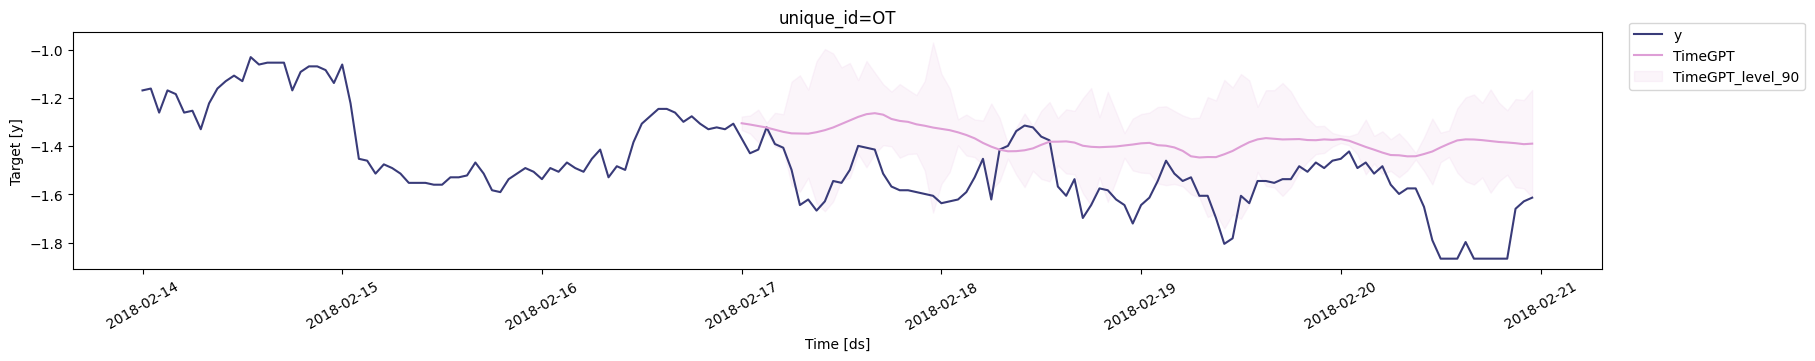

In [19]:
nixtla_client.plot(Y_df[-168:], fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')

In [20]:
test = test.copy()

test.loc[:, 'TimeGPT'] = fcst_df['TimeGPT'].values

In [21]:
evaluation = mae(test, models=['TimeGPT'], id_col='unique_id', target_col='y')

print(evaluation)

  unique_id   TimeGPT
0        OT  0.205319
